In [41]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
df = pd.read_pickle('df_model')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15268 entries, 0 to 15267
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Price                     15268 non-null  object
 1   URL                       15268 non-null  object
 2   title                     15268 non-null  object
 3   bikeTitle                 15268 non-null  object
 4   attributes                15268 non-null  object
 5   VIN                       4971 non-null   object
 6   fuel                      13649 non-null  object
 7   odometer                  13321 non-null  object
 8   paint color               9280 non-null   object
 9   title status              11466 non-null  object
 10  transmission              13683 non-null  object
 11  condition                 7520 non-null   object
 12  engine displacement (CC)  5216 non-null   object
 13  type                      5747 non-null   object
 14  year                  

In [44]:
df = df.dropna(subset =['final_years', 'final_make'])
df =df.drop(['make','make_title', 'year', 'years', 'title_lower', 'URL', 'bikeTitle', 'attributes',], axis =1)
df = df[df['final_years'].astype(str).str.isdigit()]
df['odometer'] = df.odometer.str.extract('(^\d*)')
df[["final_years"]] = df[['final_years']].apply(pd.to_numeric)
df['Price']= df['Price'].apply(lambda x: x.replace('$',''))
df['Price']= df['Price'].apply(lambda x: x.replace(',',''))
df[['Price']] = df[['Price']].apply(pd.to_numeric)
df[['odometer']] = df[['odometer']].apply(pd.to_numeric)
df =df.reset_index(drop=True)
df = df[df['Price']<50000]
df=df[df['Price']>600]
df = df[df['odometer']<100000]
df = df[df['final_years']>1960]
df = df[df['final_years']<2022]
df.drop("VIN", inplace =True, axis =1)
df =df.reset_index(drop=True)
df['condition'] = df['condition'].str.replace('excellentcryptocurrency ok', 'excellent')
df['condition'] = df['condition'].str.replace('like newcryptocurrency ok', 'like new')
df['condition'] = df['condition'].str.replace('goodcryptocurrency ok', 'good')
df['condition'] = df['condition'].str.replace('faircryptocurrency ok', 'fair')
df['condition'] = df['condition'].str.replace('newcryptocurrency ok', 'new')

In [45]:
df['fuel'] = df['fuel'].fillna(value='other')
df['paint color'] = df['paint color'].fillna(value='other')
df['title status'] = df['title status'].fillna(value='other')
df['transmission'] = df['transmission'].fillna(value='other')
df['condition'] = df['condition'].fillna(value='other')
df['engine displacement (CC)'] = df['engine displacement (CC)'].fillna(value='other')
df['type'] = df['type'].fillna(value='other')


In [47]:
# R-squared and RMSE Function
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(y_true, y_predict, squared=False)

    # Return the score
    return [r2, rmse]

## Train Test Split

In [48]:
# Use train_test_split to create training data and testing data
X = df.drop(['Price'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [49]:
# Get categoricals
categoricals = ['fuel','paint color','title status', 'transmission', 'condition', 'type', 'final_make']

train_dummies = X_train[categoricals]
test_dummies = X_test[categoricals]

# Create OneHotEncoder object to create dummies
ohe = OneHotEncoder(handle_unknown='ignore')

# Transform the dataset into dummies matrix
enc = ohe.fit(train_dummies)

train_dummies_trans = enc.transform(train_dummies)
test_dummies_trans = enc.transform(test_dummies)

# Dummies values in matrix form
train_data = train_dummies_trans.todense()
test_data = test_dummies_trans.todense()

# New dummy column names
names = ohe.get_feature_names(categoricals)

# Make them into Dataframe
train_dummies_trans_df = pd.DataFrame(train_data, columns=names)
test_dummies_trans_df = pd.DataFrame(test_data, columns=names)

In [50]:
train_dummies_trans_df = train_dummies_trans_df[train_dummies_trans_df.columns.drop(list(train_dummies_trans_df.filter(regex='other')))]
test_dummies_trans_df = test_dummies_trans_df[test_dummies_trans_df.columns.drop(list(test_dummies_trans_df.filter(regex='other')))]

In [51]:
train_dummies_trans_df.reset_index(drop=True, inplace=True)


test_dummies_trans_df.reset_index(drop=True, inplace=True)

X_train =X_train.drop(categoricals, axis=1)
X_test = X_test.drop(categoricals, axis=1)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_train_comb = pd.concat([X_train, train_dummies_trans_df], axis=1)
X_test_comb = pd.concat([X_test, test_dummies_trans_df], axis=1)

In [52]:
X_train_comb = X_train_comb.drop(['title','engine displacement (CC)'],axis=1)
X_test_comb = X_test_comb.drop(['title','engine displacement (CC)'], axis=1)

In [53]:
regressor = DecisionTreeRegressor(random_state=42)  
regressor.fit(X_train_comb, y_train)

DecisionTreeRegressor(random_state=42)

In [54]:
# Make predictions on the test set
y_pred = regressor.predict(X_test_comb) 

# Evaluate these predictions
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2599.8484461314342
Mean Squared Error: 21456953.01544591
Root Mean Squared Error: 4632.165046222544


In [55]:
score = performance(y_test, y_pred)
score

[0.47790347132024213, 4632.165046222544]

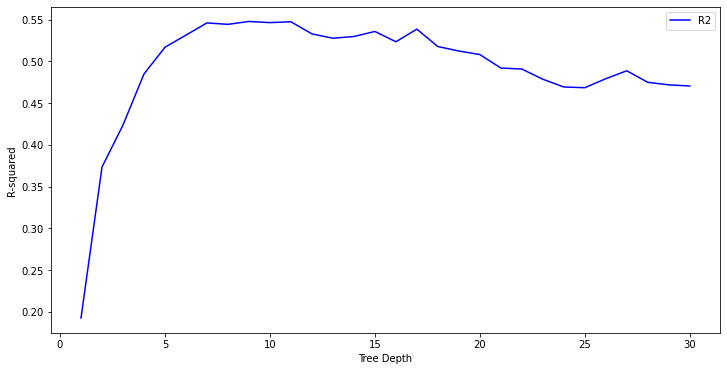

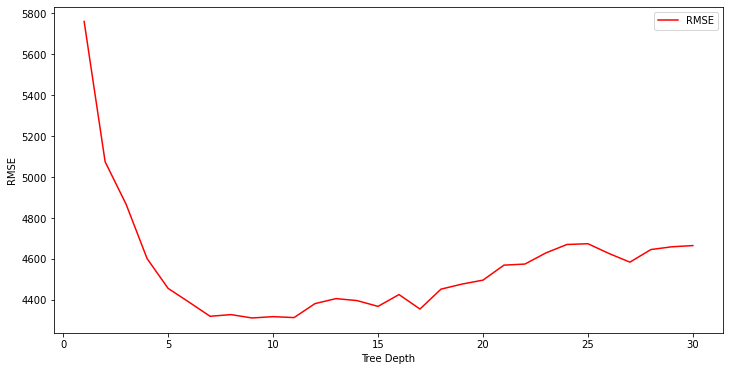

In [56]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 30, 30, endpoint=True)
mse_results = []
r2_results = []

for max_depth in max_depths:
    regressor = DecisionTreeRegressor(max_depth=max_depth, 
                                      random_state=42)
    regressor.fit(X_train_comb, y_train)
    y_pred = regressor.predict(X_test_comb)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(max_depths, r2_results, 'b', label='R2')
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(max_depths, mse_results, 'r', label='RMSE')
plt.xlabel('Tree Depth')
plt.ylabel('RMSE')
plt.legend()
plt.show()

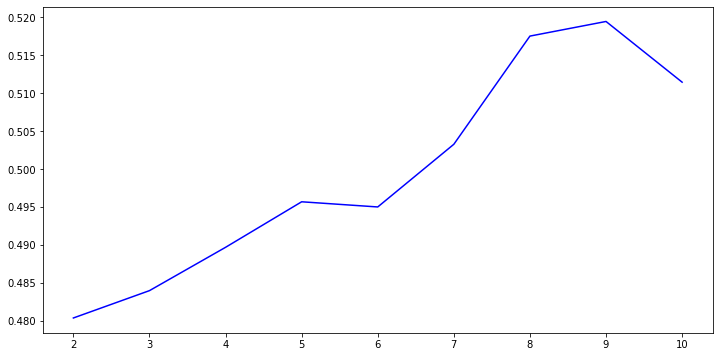

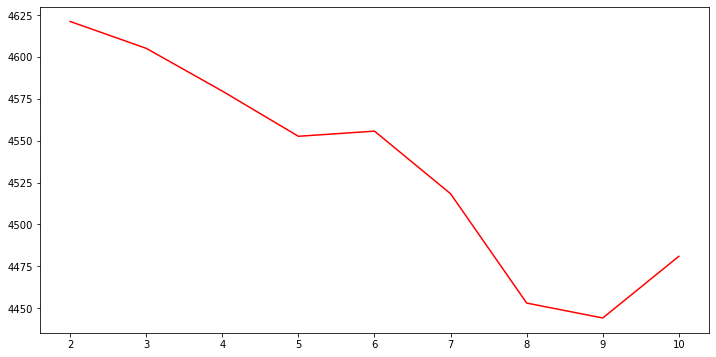

In [57]:
# Identify the optimal minimum split size for given data
min_samples_splits = np.arange(2, 11)
mse_results = []
r2_results = []

for min_samples_split in min_samples_splits:
    regressor = DecisionTreeRegressor(min_samples_split=int(min_samples_split),
                                      random_state=45)
    regressor.fit(X_train_comb, y_train)
    y_pred = regressor.predict(X_test_comb)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, r2_results, 'b', label='R2')
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, mse_results, 'r', label='RMSE')
plt.show()

In [61]:
regressor = DecisionTreeRegressor(min_samples_split=2, max_depth=11, random_state=42)
regressor.fit(X_train_comb, y_train)
y_pred = regressor.predict(X_test_comb)
score = performance(y_test, y_pred)
score[0], score[1], regressor

(0.5474326410632333,
 4312.709803913698,
 DecisionTreeRegressor(max_depth=11, random_state=42))